This part focuses on the Data Preprocessing and the Machine Learning Models.


In [1]:
# Import important packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm

# Filter out FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# This script is created in Google Colab and therefore the file is loaded from
# The private google drive
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/'

Mounted at /content/drive
/content/drive/My Drive


# Data Preprocessing

Data Preprocessing goals:

- Drop the first column which is an index.
- Handle any missing values.
- Convert categorical variables using Label Encoding.
- Split the data into features (X) and target (y).
- Split these into training and testing sets.

In [12]:
stroke_data = pd.read_csv('stroke_data_cleaned.csv')

# Quick look at the dataset
stroke_data.head()

# Drop the 'Unnamed: 0' column as it's just an index
stroke_data.drop(columns=['Unnamed: 0'], inplace=True)

# Check the values for 'smoking_status' and 'smoking status_status_imp'
#if equal delete the imputed
are_equal = stroke_data['smoking_status'].equals(stroke_data['smoking_status_imp'])

# Drop the imputed column
stroke_data.drop("smoking_status_imp",axis=1,inplace=True)

# Check for any remaining missing values
missing_values = stroke_data.isnull().sum()
stroke_data

# Fill missing values in 'bmi' with the imputed values in 'bmi_imp'
stroke_data['bmi'].fillna(stroke_data['bmi_imp'], inplace=True)
are_equal_1 = stroke_data['bmi'].equals(stroke_data['bmi_imp'])

# Drop the imputed column
stroke_data.drop("bmi_imp",axis=1,inplace=True)

stroke_data.isna().sum()


gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
rounded_age          0
dtype: int64

The first column was removed because we don't need it for the model. There were missing values in the 'bmi' column and were filled with imputed values. As a result we get our cleaned data set without missing values.

It is obvious that our data set contains many categorical variables and in the following we will encode these.

In [13]:
# Avoid introducing spurious ordinality, so better use onehot
#encoder for encoding the variables

# Define the columns to encode with one hot encoder
end_col_onehot = ["gender", "smoking_status", "work_type"]
# Initialize a new dataset, profit later visible
dataset_encoded = stroke_data

for col in end_col_onehot:
  one_hot = pd.get_dummies(dataset_encoded[col])
  dataset_encoded = dataset_encoded.drop(col, axis=1)
  dataset_encoded = dataset_encoded.join(one_hot)

# Drop the unencoded columns
dataset_encoded = dataset_encoded.iloc[:,1:]
# Dataset encoded is a separate dataset because we have to save the encoded
# Variables separately in order to decode them as well later...

# Encode with Label Encoder the binary variables ( with only 2 entries)
from sklearn.preprocessing import LabelEncoder
# Define cols
enc_col_le = ["ever_married", "Residence_type"]
label_encoder = LabelEncoder()
# Iterate through cols
for col in enc_col_le:
   dataset_encoded[col] = label_encoder.fit_transform(dataset_encoded[col])

# Ever married : 1 yes 0 no .. residence type urban 1, 0 rural
dataset_encoded

,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,rounded_age,Female,Male,Other,Unknown,formerly smoked,never smoked,smokes,Govt_job,Never_worked,Private,Self-employed,children
0,0,1,1,1,228.69,36.6,1,67.0,0,1,0,0,1,0,0,0,0,1,0,0
1,0,0,1,0,202.21,28.1,1,61.0,1,0,0,0,0,1,0,0,0,0,1,0
2,0,1,1,0,105.92,32.5,1,80.0,0,1,0,0,0,1,0,0,0,1,0,0
3,0,0,1,1,171.23,34.4,1,49.0,1,0,0,0,0,0,1,0,0,1,0,0
4,1,0,1,0,174.12,24.0,1,79.0,1,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1,0,1,1,83.75,28.1,0,80.0,1,0,0,0,0,1,0,0,0,1,0,0
5106,0,0,1,1,125.20,40.0,0,81.0,1,0,0,0,0,1,0,0,0,0,1,0
5107,0,0,1,0,82.99,30.6,0,35.0,1,0,0,0,0,1,0,0,0,0,1,0
5108,0,0,1,0,166.29,25.6,0,51.0,0,1,0,0,1,0,0,0,0,1,0,0


OneHotEncoder and LabelEncoder were used as encoding techniques because of the levels of categories present in the data. Specifically for non-binary categories to avoid spurious ordinality or even introduction of bias OneHoteEncoder was used over LabelEncoding, where for each category of the specific variable (column) a new separate column was created. this way, we also avoided the risk that the models later don't interpret the numerical labels as ordinal values and learn relationships based on the assigned numerical values which leads to incorrect assumptions about the relationships between categories as well. For columns with binary data we used the normal LabelEncoding as visible in the code above.

# Model Training

This section concemtrates on model training. Three different Models are trained:
- Decision Tree
- Random Forest
- Support Vector Machines
- Logistical Regression


After the training, the models will be evaluated using various metrics, such as accuracy, precision, recall and F1-score as part of the classification report.
Due to the big imbalace in the data set, we will use the oversamling technique of SMOTE later. Therefore, the training part is divided in two parts; first we train the models without SMOTE and after we train the models on the oversampled data set, in order to see the difference.

In [25]:
# Divide the training data
X = dataset_encoded.drop(['stroke'], axis=1)  # features
y = dataset_encoded['stroke']  # target

# Split the data again into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardizing(scaling) the data
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)


Since we want to compare the performance of different models at a later point, we considered standardizing the data. Additionally, standardization makes the data less sensistive to outliers and will help our models to converge faster and provide more efficiency.

In [35]:
#define training function

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
def train_models(models, X_train, y_train):
    """
    Train multiple classification models.

    Returns:
    - trained_models (dict): Dictionary containing trained model instances.
    """

    trained_models = {}

    for model_name, model_instance in models:
        model = model_instance
        model.fit(X_train, y_train)
        trained_models[model_name] = model

    return trained_models

# Save hte trained data for future predictions
def train_saving(models, trained_models, X_train, y_train):
    """
    Save the training data for multiple classification models.

    Returns:
    - trained_models (dict): Dictionary containing trained model instances with saved training data.
    """
    # Save the training data for each model
    for model_name, trained_data in trained_models.items():
        trained_models[model_name] = {
            'model': trained_data['model'],
            'X_train': X_train,
            'y_train': y_train
        }

    return trained_models


def evaluate_models(models, trained_models, X_test, y_test):
    """
    Evaluate multiple classification models.

    Returns:
    - results (list): List of evaluation results for each model.
    """

    results = []

    for model_name, model_instance in models:
        lst_2 = []
        model = trained_models[model_name]

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Compute evaluation metrics
        cm = confusion_matrix(y_test, y_pred)  # Confusion Matrix
        accuracies = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10)  # K-Fold Validation
        roc = roc_auc_score(y_test, y_pred)  # ROC AUC Score
        precision = precision_score(y_test, y_pred)  # Precision Score
        recall = recall_score(y_test, y_pred)  # Recall Score
        f1 = f1_score(y_test, y_pred)  # F1 Score

        # Print evaluation metrics
        print(f"{model_name}:")
        print("Confusion Matrix:")
        print(cm)
        print('Accuracy Score:', accuracy_score(y_test, y_pred))
        print('')
        print("K-Fold Validation Mean Accuracy: {:.2f} %".format(accuracies.mean() * 100))
        print("Standard Deviation: {:.2f} %".format(accuracies.std() * 100))
        print('ROC AUC Score: {:.2f}'.format(roc))
        print('Precision: {:.2f}'.format(precision))
        print('Recall: {:.2f}'.format(recall))
        print('F1: {:.2f}'.format(f1))
        print('-----------------------------------')
        print('')

        # Append evaluation results to list
        lst_2.append(model_name)
        lst_2.append((accuracy_score(y_test, y_pred)) * 100)
        lst_2.append(accuracies.mean() * 100)
        lst_2.append(accuracies.std() * 100)
        lst_2.append(roc)
        lst_2.append(precision)
        lst_2.append(recall)
        lst_2.append(f1)
        results.append(lst_2)

    return results


In [36]:
# Define the models
models = [
    ['Logistic Regression', LogisticRegression(random_state=0,max_iter=10000)],
    ['SVM', SVC(random_state=0)],
    ['Decision Tree', DecisionTreeClassifier(random_state=0)],
    ['Random Forest', RandomForestClassifier(random_state=0)],
]

# Train models
trained_models = train_models(models, X_train_std, y_train)

# Evaluate models
evaluation_results = evaluate_models(models, trained_models, X_test_std, y_test)


Logistic Regression:
Confusion Matrix:
[[972   0]
 [ 49   1]]
Accuracy Score: 0.952054794520548

K-Fold Validation Mean Accuracy: 95.11 %
Standard Deviation: 0.11 %
ROC AUC Score: 0.51
Precision: 1.00
Recall: 0.02
F1: 0.04
-----------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM:
Confusion Matrix:
[[972   0]
 [ 50   0]]
Accuracy Score: 0.9510763209393346

K-Fold Validation Mean Accuracy: 95.13 %
Standard Deviation: 0.07 %
ROC AUC Score: 0.50
Precision: 0.00
Recall: 0.00
F1: 0.00
-----------------------------------

Decision Tree:
Confusion Matrix:
[[926  46]
 [ 40  10]]
Accuracy Score: 0.9158512720156555

K-Fold Validation Mean Accuracy: 91.07 %
Standard Deviation: 1.08 %
ROC AUC Score: 0.58
Precision: 0.18
Recall: 0.20
F1: 0.19
-----------------------------------

Random Forest:
Confusion Matrix:
[[970   2]
 [ 50   0]]
Accuracy Score: 0.949119373776908

K-Fold Validation Mean Accuracy: 95.03 %
Standard Deviation: 0.22 %
ROC AUC Score: 0.50
Precision: 0.00
Recall: 0.00
F1: 0.00
-----------------------------------



## SMOTE

SMOTE is applied as a measure to imbalaced data.
COMMENT THE REASON LATER

SMOTE APPLY 

Data shapes before oversampling were (4088, 19) and (4088,)
Data shapes after oversampling were (7778, 19) and (7778,)
0    3889
1    3889
Name: stroke, dtype: int64


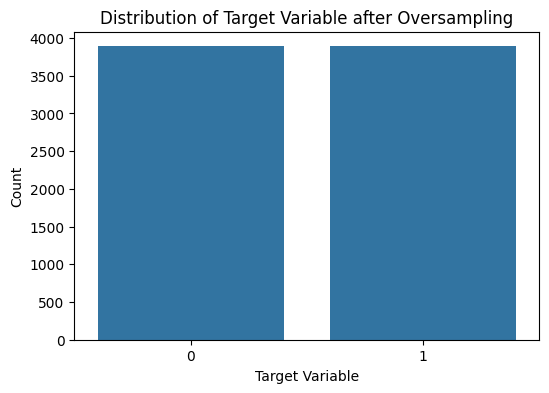

In [29]:
print("SMOTE APPLY \n")
#it makes sence to apply smote because the data is biased and imbalanced which
#may cause biased models at the end which will fail to make accurate predictions

#initiation of smote
oversample = SMOTE(random_state=42)
#fit smote to training sample
X_res, y_res = oversample.fit_resample(X_train_std, y_train)
print('Data shapes before oversampling were {0} and {1}'.format(X_train_std.shape, y_train.shape))
print('Data shapes after oversampling were {0} and {1}'.format(X_res.shape, y_res.shape))
print(y_res.value_counts())

#distribution after oversampling
plt.figure(figsize=(6, 4))
sns.countplot(x=y_res)
plt.title('Distribution of Target Variable after Oversampling')
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['0', '1'])  # Optionally, set custom tick labels
plt.show()


In [30]:
# Train models
trained_models = train_models(models, X_res, y_res)

# Evaluate models
evaluation_results = evaluate_models(models, trained_models, X_test_std, y_test)

Logistic Regression:
Confusion Matrix:
[[724 248]
 [ 10  40]]
Accuracy Score: 0.7475538160469667

K-Fold Validation Mean Accuracy: 95.11 %
Standard Deviation: 0.11 %
ROC AUC Score: 0.77
Precision: 0.14
Recall: 0.80
F1: 0.24
-----------------------------------

SVM:
Confusion Matrix:
[[804 168]
 [ 26  24]]
Accuracy Score: 0.8101761252446184

K-Fold Validation Mean Accuracy: 95.13 %
Standard Deviation: 0.07 %
ROC AUC Score: 0.65
Precision: 0.12
Recall: 0.48
F1: 0.20
-----------------------------------

Decision Tree:
Confusion Matrix:
[[882  90]
 [ 36  14]]
Accuracy Score: 0.8767123287671232

K-Fold Validation Mean Accuracy: 91.07 %
Standard Deviation: 1.08 %
ROC AUC Score: 0.59
Precision: 0.13
Recall: 0.28
F1: 0.18
-----------------------------------

Random Forest:
Confusion Matrix:
[[918  54]
 [ 42   8]]
Accuracy Score: 0.9060665362035225

K-Fold Validation Mean Accuracy: 95.03 %
Standard Deviation: 0.22 %
ROC AUC Score: 0.55
Precision: 0.13
Recall: 0.16
F1: 0.14
---------------------

COMMENT THE RESULTS